<a href="https://colab.research.google.com/github/VishanOberoi/DeepLearning/blob/main/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvNet for multiclass classification of Traffic Signs


Dataset : https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [4]:
#Getting the dataset

!kaggle datasets list -s gtsrb-german-traffic-sign


ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          71990        905  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           9343        239  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            335          8  0.75             
bhavinmoriya/german-traffic-sign-recognition-bench

In [5]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

100% 612M/612M [00:30<00:00, 23.0MB/s]
100% 612M/612M [00:30<00:00, 21.0MB/s]
/content


In [6]:
# Unzipping downloaded file and removing unusable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

In [7]:
#imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from keras import utils
from keras.utils import to_categorical

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

In [8]:
# Plotting 12 images to check dataset

path = "traffic_sign_dataset/Test"
def plot_few_imgs(path):
  plt.figure(figsize=(12,12))
  for i in range(1,13):
      plt.subplot(4,4,i)
      plt.tight_layout()
      rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
      plt.imshow(rand_img)
      plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
      plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image


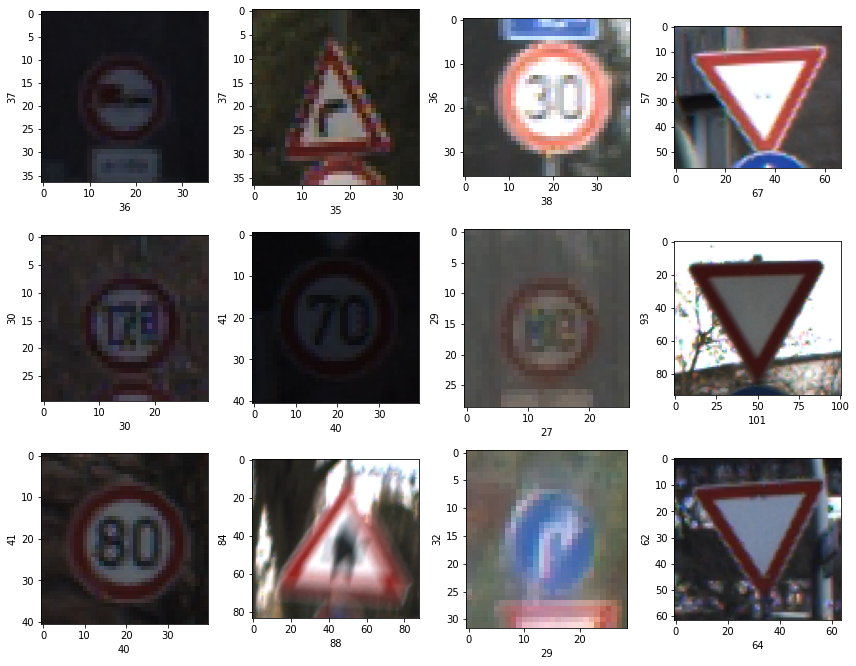

In [9]:
plot_few_imgs(path)

#As seen above the dimensions of the images are varying.
To make them uniform we take the mean of all dims


#There are 43 classes of images in the dataset

finding the dims for each

In [10]:
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [11]:
print("Dim 1 Mean = " , np.mean(dim1), "\nDim 2 Mean = ", np.mean(dim2))

Dim 1 Mean =  50.328929582493814 
Dim 2 Mean =  50.83587951745773


In [12]:
#Reshaping to 50,50
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [13]:
#Converting images into numpy array
images = np.array(images)
#Normalising the 0 to 255 range to 0,1 by dividing by 255
images = images/255 

In [14]:
label_id = np.array(label_id)
label_id.shape

(39209,)

In [15]:
images.shape

(39209, 50, 50, 3)

#There are 39209 color images of dim 50,50

In [16]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

In [17]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

In [18]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [19]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [20]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [21]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
246/246 - 13s - loss: 2.5829 - accuracy: 0.3014 - val_loss: 1.2429 - val_accuracy: 0.6941 - 13s/epoch - 53ms/step
Epoch 2/10
246/246 - 4s - loss: 1.2374 - accuracy: 0.6131 - val_loss: 0.5016 - val_accuracy: 0.8750 - 4s/epoch - 17ms/step
Epoch 3/10
246/246 - 4s - loss: 0.8579 - accuracy: 0.7262 - val_loss: 0.3193 - val_accuracy: 0.9346 - 4s/epoch - 17ms/step
Epoch 4/10
246/246 - 4s - loss: 0.6633 - accuracy: 0.7847 - val_loss: 0.2451 - val_accuracy: 0.9522 - 4s/epoch - 17ms/step
Epoch 5/10
246/246 - 4s - loss: 0.5710 - accuracy: 0.8170 - val_loss: 0.1903 - val_accuracy: 0.9660 - 4s/epoch - 17ms/step
Epoch 6/10
246/246 - 4s - loss: 0.4902 - accuracy: 0.8409 - val_loss: 0.1565 - val_accuracy: 0.9670 - 4s/epoch - 17ms/step
Epoch 7/10
246/246 - 4s - loss: 0.4498 - accuracy: 0.8538 - val_loss: 0.1171 - val_accuracy: 0.9749 - 4s/epoch - 17ms/step
Epoch 8/10
246/246 - 4s - loss: 0.4044 - accuracy: 0.8669 - val_loss: 0.1042 - val_accuracy: 0.9767 - 4s/epoch - 17ms/step
Epoch 9/10
246

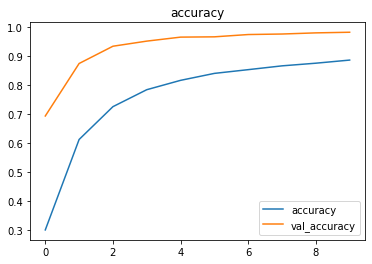

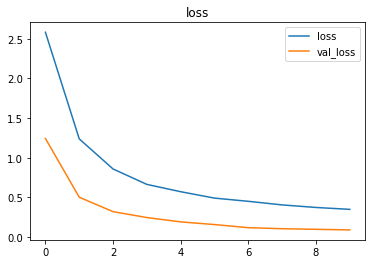

In [22]:
def plot_hist(model):
  evaluation = pd.DataFrame(model.history.history)
  evaluation[['accuracy', 'val_accuracy']].plot(title = 'accuracy')
  evaluation[['loss', 'val_loss']].plot(title = 'loss')
plot_hist(model)

In [25]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv #not useful

rm: cannot remove 'traffic_sign_dataset/Test/GT-final_test.csv': No such file or directory


In [24]:
#defining a function that will scale images
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images
    
    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)
    #The pixel value of each image ranges between 0 and 255
    #Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
    images = images/255

    return images

In [27]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

In [45]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [29]:
y_pred = model.predict(test_images);
y_pred

395/395 [==============================] - 2s 5ms/step


array([[7.1897279e-20, 5.0670892e-18, 1.3049202e-18, ..., 7.0068846e-19,
        2.0008352e-23, 4.4547525e-13],
       [4.9833173e-04, 9.9862349e-01, 5.6663452e-04, ..., 4.8149191e-16,
        8.0788154e-21, 9.9657939e-17],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.6903783e-20,
        1.7529803e-30, 2.6510022e-37],
       ...,
       [4.5948716e-05, 5.9613748e-04, 2.4357818e-03, ..., 2.2780076e-03,
        1.7284299e-04, 1.5425138e-04],
       [2.4200121e-05, 1.2213223e-03, 1.5053836e-03, ..., 9.8055727e-07,
        2.9462985e-09, 5.7319276e-06],
       [1.4950611e-08, 1.2396999e-06, 1.4593443e-05, ..., 4.7052649e-06,
        2.9250921e-06, 1.9938190e-04]], dtype=float32)

In [40]:
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']


In [58]:
y_pred =  model.predict(test_images)
y_pred

395/395 [==============================] - 2s 4ms/step


array([[7.1897279e-20, 5.0670892e-18, 1.3049202e-18, ..., 7.0068846e-19,
        2.0008352e-23, 4.4547525e-13],
       [4.9833173e-04, 9.9862349e-01, 5.6663452e-04, ..., 4.8149191e-16,
        8.0788154e-21, 9.9657939e-17],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.6903783e-20,
        1.7529803e-30, 2.6510022e-37],
       ...,
       [4.5948716e-05, 5.9613748e-04, 2.4357818e-03, ..., 2.2780076e-03,
        1.7284299e-04, 1.5425138e-04],
       [2.4200121e-05, 1.2213223e-03, 1.5053836e-03, ..., 9.8055727e-07,
        2.9462985e-09, 5.7319276e-06],
       [1.4950611e-08, 1.2396999e-06, 1.4593443e-05, ..., 4.7052649e-06,
        2.9250921e-06, 1.9938190e-04]], dtype=float32)

In [76]:
y_pred_class = np.argmax(y_pred, axis=-1)
y_pred_class

array([16,  1, 38, ...,  5,  7, 10])

#Visualising one image with its prediction

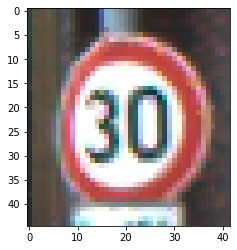

In [43]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
plt.imshow(img)

In [46]:
# Original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


In [77]:
# Predicted label
print("Predicted label : ",all_lables[y_pred_class[1]])
# all_lables[np.argmax(y_pred[1])]

Predicted label :  Speed limit (30km/h)


#Conclusion

In this project, I carried out a multiclass classification problem, and managed to achieve a validation accuracy of 98.28%